In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

%matplotlib inline

C:\Users\user\AppData\Local\Temp\ipykernel_17892\4213999422.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [12]:
class ApsundNokeModel():
    def __init__(self, distr, data, n_depth = 20000):
        self.distr = distr
        self.setData(data)
        self.n_depth = n_depth
    
    def setData(self, data):
        self.data = data
        self.n_epochs = data.shape[0]
        self.k_params = 0
        for x in self.data.columns:
            if x[0:5] == "param":
                self.k_params+=1

    def getParams(self, epoch):
        params = (self.data[f"param_0"][epoch],)
        for i in range(1, self.k_params):
            params += (self.data[f"param_{i}"][epoch],)
        return params
        
    
    def Sigma2(self, C, epoch):
        sigma = self.data["sigma"][epoch]
        return (1+sigma*np.sum(C))/(1+sigma*len(C))
    
    def expectedProfit_montecarlo(self, C, epoch, sigma2 = None):
        f = self.data["f"][epoch]
        S = self.data["S"][epoch]
        params = self.getParams(epoch)
        n = self.n_depth
        if sigma2 == None:
            sigma2 = self.Sigma2(C, epoch)
        if self.distr == np.random.uniform:
            a, b = params[0], params[1]
            if sigma2 > b:
                return S*0.125*(sigma2**2-sigma2*(b+a)+1/3*(b**2+b*a+a**2))-f
            if sigma2 < a:
                return -f
            return S * 1/24*(sigma2-a)**3/(b-a)-f
        
        answ = 0
        for i in range(n):
            cc = np.abs(self.distr(*params))
            answ -= f
            if cc<= sigma2:
                answ += S * 1/8*(sigma2-cc)**2
        return answ/n

    def NPV_for_entrant(self, C, epoch, sigma2 = None):
        r = self.data["r"][epoch]
        return ((1+r)/r) * self.expectedProfit_montecarlo(C, epoch, sigma2)
    
    def scenario(self, out = False):
        #data prepare
        NPV_ent = [0] * self.n_epochs
        M = [0] * self.n_epochs
        P_mean = [0] * self.n_epochs
        EP_ = [0] * self.n_epochs
        C_mean = [0] * self.n_epochs
        C_max = [0] * self.n_epochs
        Sigma2 = [0] * self.n_epochs
        M_ent = [0] * self.n_epochs
        M_ex = [0] * self.n_epochs

        #zero epoch
        params = self.getParams(0)
        C = np.abs(self.distr(*params, size = 10))
        
        for epoch in range(self.n_epochs):
            #loading data
            params = self.getParams(epoch)
            f = self.data["f"][epoch]
            r = self.data["r"][epoch]
            ef = self.data["ef"][epoch]
            alpha = self.data["alpha"][epoch]
            sigma = self.data["sigma"][epoch]
            S = self.data["S"][epoch]

            NPV1 = self.NPV_for_entrant(C, epoch)
            EP = self.expectedProfit_montecarlo(C, epoch)

            #entrance stage
            n_ent = 0
            while NPV1 > ef:
                c = np.abs(self.distr(*params, size = 1))
                C = np.append(C, c)
                n_ent += 1
                NPV1 = self.NPV_for_entrant(C, epoch)

            #recounting stage
            for i in range(len(C)):
                a = random.random()
                if a > alpha:
                    C[i] = np.abs(self.distr(*params))
            
            # sort of C
            C = np.flip(np.sort(C))

            # exit stage
            sigma2 = self.Sigma2(C, epoch)
            EP = self.expectedProfit_montecarlo(C, epoch, sigma2)
            n_ex = 0
            i = 0
            P_fact = []
            while (i < len(C)):
                P = - f
                if sigma2 > C[i]:
                    P = S * 1/8*(sigma2 - C[i])**2 - f
                P_fact.append(P)
                NPV2 = (1+r)/(1+r-alpha) * P + (1/r - alpha/(1+r-alpha))*EP
                if NPV2 < 0:
                    C = np.delete(C, i)
                    n_ex += 1
                    sigma2 = self.Sigma2(C, epoch)
                    EP = self.expectedProfit_montecarlo(C, epoch, sigma2)
                else:
                    i += 1
                
            NPV_ent[epoch] = NPV1
            M[epoch] = len(C)
            P_mean[epoch] = np.mean(P_fact)
            EP_[epoch] = EP
            C_mean[epoch] = np.mean(C)
            C_max[epoch] = np.max(C)
            Sigma2[epoch] = sigma2
            M_ent[epoch] = n_ent
            M_ex[epoch] = n_ex

            if out:
                print(f"epoch{epoch}, number of firms: {M[epoch]}, entrats: {M_ent[epoch]}, exiters: {M_ex[epoch]}, EP: {EP_[epoch]}, C_mean: {C_mean[epoch]}, EP_fact: {P_mean[epoch]}")
        
        self.data["NPV_ent"] = NPV_ent
        self.data["n_firms"] = M
        self.data["Pr_mean"] = P_mean
        self.data["EP"] = EP_
        self.data["C_mean"] = C_mean
        self.data["C_max"] = C_max
        self.data["Sigma2"] = Sigma2
        self.data["n_entr"] = M_ent
        self.data["n_ext"] = M_ex

    def getData(self):
        return self.data

In [28]:
#parameters of distribution
Ec = 0.2
Dc = 0.01
scale = Dc**0.5

#parameters of utility
sigma = 0.5
S = 16

#parameters of firms
f = 0.01 # fixed costs
ef = 0.01 # entrance costs
r = 0.01 #return of interest
alpha = 0.9
a=0.1
b=0.2

n = 200

data = {"param_0": [a]*n,
        "param_1": [b]*n,
        "sigma": [sigma]*n,
        "S": [S]*n,
        "f": [f]*n,
        "ef": [ef]*n,
        "r": [r]*n,
        "alpha": [alpha]*n}

df = pd.DataFrame(data)
df

,param_0,param_1,sigma,S,f,ef,r,alpha
0,0.1,0.2,0.5,16,0.01,0.01,0.01,0.9
1,0.1,0.2,0.5,16,0.01,0.01,0.01,0.9
2,0.1,0.2,0.5,16,0.01,0.01,0.01,0.9
3,0.1,0.2,0.5,16,0.01,0.01,0.01,0.9
4,0.1,0.2,0.5,16,0.01,0.01,0.01,0.9
...,...,...,...,...,...,...,...,...
195,0.1,0.2,0.5,16,0.01,0.01,0.01,0.9
196,0.1,0.2,0.5,16,0.01,0.01,0.01,0.9
197,0.1,0.2,0.5,16,0.01,0.01,0.01,0.9
198,0.1,0.2,0.5,16,0.01,0.01,0.01,0.9


In [29]:
Noke = ApsundNokeModel(distr = np.random.uniform,
                       data = df)

In [30]:
Noke.scenario(out=True)

epoch0, number of firms: 19, entrats: 15, exiters: 6, EP: 0.0008128749356376436, C_mean: 0.13526943864098334, EP_fact: 0.0013732855192666316
epoch1, number of firms: 18, entrats: 2, exiters: 3, EP: 0.0006052173631829905, C_mean: 0.1298362656136755, EP_fact: 0.00403413999808844
epoch2, number of firms: 17, entrats: 1, exiters: 2, EP: 0.0010564151555469154, C_mean: 0.12658022914336395, EP_fact: 0.006172909833946501
epoch3, number of firms: 18, entrats: 1, exiters: 0, EP: 0.0005804684382647047, C_mean: 0.12973336067670604, EP_fact: 0.005910956648202289
epoch4, number of firms: 17, entrats: 1, exiters: 2, EP: 0.0007569010658745618, C_mean: 0.12534895312624816, EP_fact: 0.006226900614624619
epoch5, number of firms: 17, entrats: 1, exiters: 1, EP: 0.0005060420383319487, C_mean: 0.12430199424004051, EP_fact: 0.006862785011539449
epoch6, number of firms: 17, entrats: 1, exiters: 1, EP: 0.0011381213177409383, C_mean: 0.126912694056221, EP_fact: 0.0066481804830026275
epoch7, number of firms: 17,

In [31]:
result = Noke.getData()
result

,param_0,param_1,sigma,S,f,ef,r,alpha,NPV_ent,n_firms,Pr_mean,EP,C_mean,C_max,Sigma2,n_entr,n_ext
0,0.1,0.2,0.5,16,0.01,0.01,0.01,0.9,-0.000791,19,0.001373,0.000813,0.135269,0.171311,0.217625,15,6
1,0.1,0.2,0.5,16,0.01,0.01,0.01,0.9,-0.070163,18,0.004034,0.000605,0.129836,0.166468,0.216853,2,3
2,0.1,0.2,0.5,16,0.01,0.01,0.01,0.9,-0.072460,17,0.006173,0.001056,0.126580,0.162174,0.218519,1,2
3,0.1,0.2,0.5,16,0.01,0.01,0.01,0.9,-0.008361,18,0.005911,0.000580,0.129733,0.162174,0.216760,1,0
4,0.1,0.2,0.5,16,0.01,0.01,0.01,0.9,-0.063022,17,0.006227,0.000757,0.125349,0.154968,0.217417,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.1,0.2,0.5,16,0.01,0.01,0.01,0.9,-0.079827,17,0.006936,0.000576,0.124596,0.153272,0.216743,1,1
196,0.1,0.2,0.5,16,0.01,0.01,0.01,0.9,-0.059595,17,0.006678,0.001102,0.126768,0.159945,0.218687,1,1
197,0.1,0.2,0.5,16,0.01,0.01,0.01,0.9,-0.005115,18,0.006187,0.001062,0.131710,0.196437,0.218539,1,0
198,0.1,0.2,0.5,16,0.01,0.01,0.01,0.9,0.008275,18,0.004952,0.000630,0.129939,0.159945,0.216945,1,1


In [32]:
np.mean(result['C_mean'])

0.127475862476393

In [52]:
sigma2 = 0.215
S * 1/24*(sigma2-a)**3/(b-a)-f

0.00013916666666666418

In [50]:
result.to_csv("results.csv")

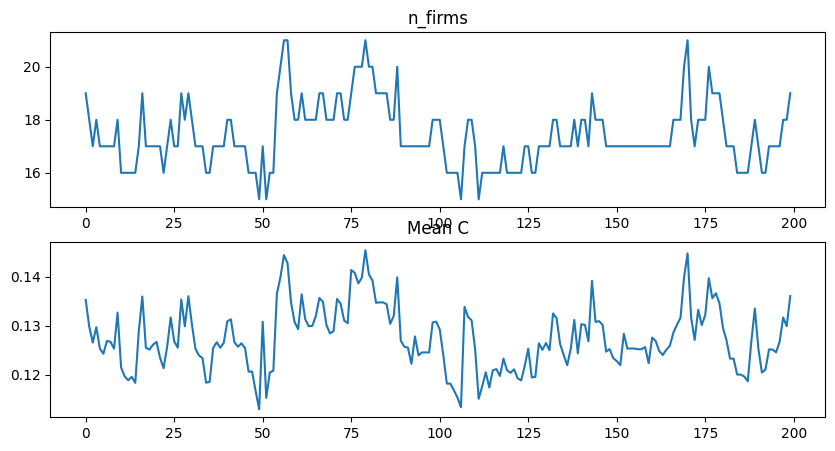

In [38]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.title('n_firms')
plt.plot(result["n_firms"])
plt.subplot(2,1,2)
plt.title('Mean C')
plt.plot(result["C_mean"])

In [62]:
#ШОК СТАВОЧКИ

for i in range(100, 200):
    df["r"][i] = 0.2

Noke.setData(df)
Noke.scenario(out = True)

epoch0, number of firms: 61, entrats: 51, exiters: 0, EP: 0.00018975874526580973, C_mean: 0.39334321329612737, EP_fact: 0.00025463427204193607
epoch1, number of firms: 61, entrats: 0, exiters: 0, EP: 0.00034153738020542643, C_mean: 0.39809191376277075, EP_fact: 0.00036010954529708017
epoch2, number of firms: 94, entrats: 33, exiters: 0, EP: 0.00018264391645274238, C_mean: 0.3998746424856626, EP_fact: 0.0003472013464105985
epoch3, number of firms: 14, entrats: 0, exiters: 80, EP: -0.00011315873236499344, C_mean: 0.31668122867635795, EP_fact: 0.00010922546285739392
epoch4, number of firms: 14, entrats: 0, exiters: 0, EP: 0.00041125262029665364, C_mean: 0.3362241006648042, EP_fact: 0.003643085204422762
epoch5, number of firms: 16, entrats: 2, exiters: 0, EP: 0.0005040644536548307, C_mean: 0.3494730375680753, EP_fact: 0.00266100046529401
epoch6, number of firms: 30, entrats: 14, exiters: 0, EP: 0.00029367314162736906, C_mean: 0.3768419695290434, EP_fact: 0.0008976946951697729
epoch7, numbe

C:\Users\user\AppData\Local\Temp\ipykernel_18440\1158626001.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["r"][i] = 0.2
C:\Users\user\AppData\Local\Temp\ipykernel_18440\1158626001.py:4: SettingWithCopyWarning: 
A value is trying to 

In [63]:
result2 = Noke.getData()
result2

,param_0,param_1,sigma,S,f,ef,r,alpha,NPV_ent,n_firms,Pr_mean,EP,C_mean,Sigma2,n_entr,n_ext
0,0.3,0.5,0.5,4,0.001,0.01,0.02,0.8,0.009654,61,0.000255,0.000190,0.393343,0.412602,51,0
1,0.3,0.5,0.5,4,0.001,0.01,0.02,0.8,0.009678,61,0.000360,0.000342,0.398092,0.417200,0,0
2,0.3,0.5,0.5,4,0.001,0.01,0.02,0.8,0.008499,94,0.000347,0.000183,0.399875,0.412377,33,0
3,0.3,0.5,0.5,4,0.001,0.01,0.02,0.8,0.009315,14,0.000109,-0.000113,0.316681,0.402096,0,80
4,0.3,0.5,0.5,4,0.001,0.01,0.02,0.8,-0.005771,14,0.003643,0.000411,0.336224,0.419196,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.3,0.5,0.5,4,0.001,0.01,0.20,0.8,0.007683,22,0.001824,0.001088,0.384538,0.435827,0,0
196,0.3,0.5,0.5,4,0.001,0.01,0.20,0.8,0.006529,22,0.001681,0.001235,0.387937,0.438942,0,0
197,0.3,0.5,0.5,4,0.001,0.01,0.20,0.8,0.007411,22,0.001692,0.001719,0.398158,0.448311,0,0
198,0.3,0.5,0.5,4,0.001,0.01,0.20,0.8,0.008948,25,0.001508,0.002016,0.409812,0.453530,3,0


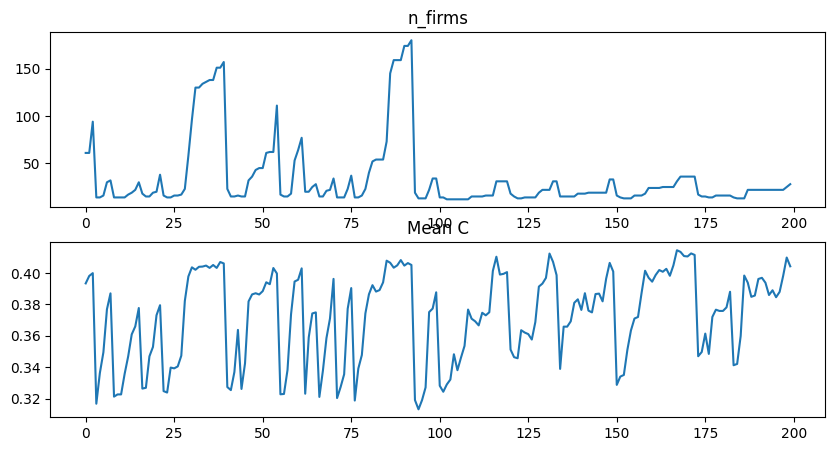

In [64]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.title('n_firms')
plt.plot(result2["n_firms"])
plt.subplot(2,1,2)
plt.title('Mean C')
plt.plot(result2["C_mean"])

In [65]:
#СТАВОЧКУ НА РОДИНУ

for i in range(100, 200):
    df["r"][i] = 0.02

C:\Users\user\AppData\Local\Temp\ipykernel_18440\2385421624.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["r"][i] = 0.02
C:\Users\user\AppData\Local\Temp\ipykernel_18440\2385421624.py:4: SettingWithCopyWarning: 
A value is trying to

In [66]:
#ШОК КОСТОВ

for i in range(100, 200):
    df["f"][i] = 0.002

Noke.setData(df)
Noke.scenario(out = False)

C:\Users\user\AppData\Local\Temp\ipykernel_18440\468035543.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["f"][i] = 0.002
C:\Users\user\AppData\Local\Temp\ipykernel_18440\468035543.py:4: SettingWithCopyWarning: 
A value is trying to 

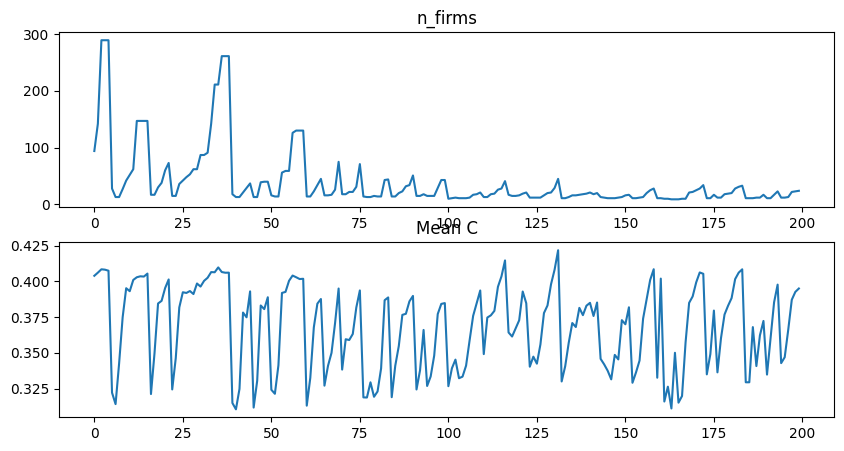

In [67]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.title('n_firms')
plt.plot(result2["n_firms"])
plt.subplot(2,1,2)
plt.title('Mean C')
plt.plot(result2["C_mean"])

In [28]:
#КОСТЫ НА РОДИНУ

for i in range(100, 200):
    df["f"][i] = 0.001

C:\Users\user\AppData\Local\Temp\ipykernel_18440\2304676190.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["f"][i] = 0.001
C:\Users\user\AppData\Local\Temp\ipykernel_18440\2304676190.py:4: SettingWithCopyWarning: 
A value is trying t

In [29]:
#ШОК КОСТОВ ВХОДА

for i in range(100, 200):
    df["ef"][i] = 0.05

Noke.setData(df)
Noke.scenario(out = False)

C:\Users\user\AppData\Local\Temp\ipykernel_18440\2251964738.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["ef"][i] = 0.05
C:\Users\user\AppData\Local\Temp\ipykernel_18440\2251964738.py:4: SettingWithCopyWarning: 
A value is trying t

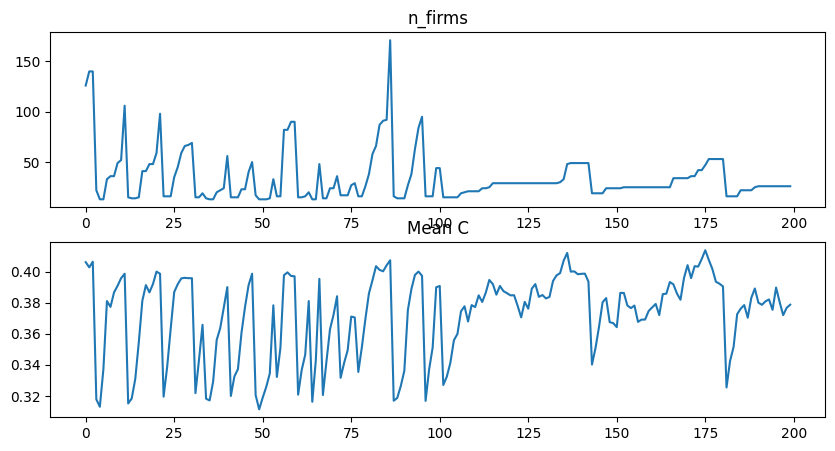

In [30]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.title('n_firms')
plt.plot(result2["n_firms"])
plt.subplot(2,1,2)
plt.title('Mean C')
plt.plot(result2["C_mean"])

In [32]:
#ШОК КОСТОВ ВХОДА НА РОДИНУ

for i in range(100, 200):
    df["ef"][i] = 0.1


# ТЕХНОШОК
for i in range(100, 200):
    df["param_0"][i] = 0.1
    df["param_1"][i] = 0.3

df

C:\Users\user\AppData\Local\Temp\ipykernel_18440\3370765154.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["ef"][i] = 0.1
C:\Users\user\AppData\Local\Temp\ipykernel_18440\3370765154.py:4: SettingWithCopyWarning: 
A value is trying to

,param_0,param_1,sigma,S,f,ef,r,alpha,NPV_ent,n_firms,Pr_mean,EP,C_mean,Sigma2,n_entr,n_ext
0,0.3,0.5,0.5,4,0.001,0.01,0.02,0.8,0.009948,126,0.000161,0.000281,0.406123,0.415403,116,0
1,0.3,0.5,0.5,4,0.001,0.01,0.02,0.8,0.009765,140,0.000025,0.000146,0.402782,0.411193,14,0
2,0.3,0.5,0.5,4,0.001,0.01,0.02,0.8,0.007429,140,0.000042,0.000259,0.406390,0.414751,0,0
3,0.3,0.5,0.5,4,0.001,0.01,0.02,0.8,0.009892,22,-0.000372,-0.000652,0.317872,0.374716,90,208
4,0.3,0.5,0.5,4,0.001,0.01,0.02,0.8,-0.033273,13,0.001951,-0.000044,0.313098,0.404685,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.1,0.3,0.5,4,0.001,0.10,0.02,0.8,0.022538,26,0.001862,0.000977,0.389782,0.433369,0,0
196,0.1,0.3,0.5,4,0.001,0.10,0.02,0.8,0.049822,26,0.001374,0.000618,0.380497,0.424747,0,0
197,0.1,0.3,0.5,4,0.001,0.10,0.02,0.8,0.031506,26,0.001257,0.000331,0.372031,0.416886,0,0
198,0.1,0.3,0.5,4,0.001,0.10,0.02,0.8,0.016870,26,0.001284,0.000487,0.376775,0.421291,0,0


In [35]:
Noke.setData(df)
Noke.scenario(out = False)

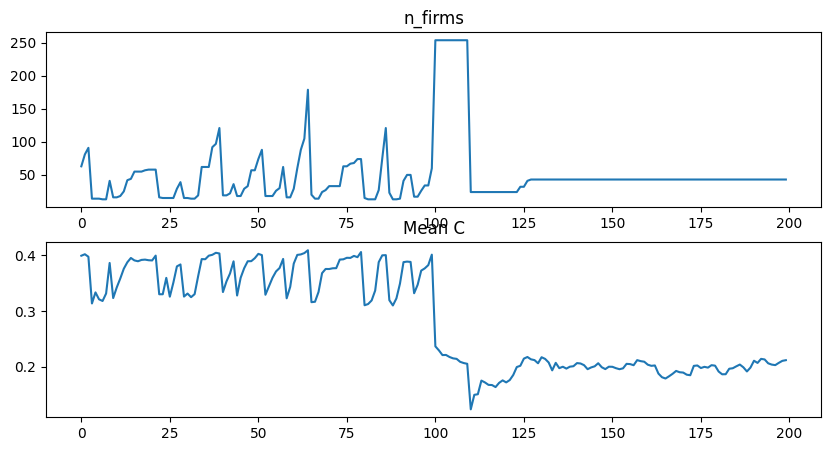

In [36]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.title('n_firms')
plt.plot(result2["n_firms"])
plt.subplot(2,1,2)
plt.title('Mean C')
plt.plot(result2["C_mean"])

In [40]:
# ТЕХНОШОК НА РОДИНУ
for i in range(100, 200):
    df["param_0"][i] = 0.3
    df["param_1"][i] = 0.5

# ШОК СПРОСА

for i in range(100, 200):
    df["S"][i] = 6

df

C:\Users\user\AppData\Local\Temp\ipykernel_18440\2562943351.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["param_0"][i] = 0.3
C:\Users\user\AppData\Local\Temp\ipykernel_18440\2562943351.py:3: SettingWithCopyWarning: 
A value is tryi

,param_0,param_1,sigma,S,f,ef,r,alpha,NPV_ent,n_firms,Pr_mean,EP,C_mean,Sigma2,n_entr,n_ext
0,0.3,0.5,0.5,4,0.001,0.01,0.02,0.8,0.009549,63,0.000246,0.000361,0.399275,0.417759,53,0
1,0.3,0.5,0.5,4,0.001,0.01,0.02,0.8,0.009969,81,0.000316,0.000312,0.401913,0.416325,18,0
2,0.3,0.5,0.5,4,0.001,0.01,0.02,0.8,0.009922,91,0.000228,0.000121,0.397440,0.410398,10,0
3,0.3,0.5,0.5,4,0.001,0.01,0.02,0.8,0.006184,14,0.000035,-0.000180,0.313651,0.399444,0,77
4,0.3,0.5,0.5,4,0.001,0.01,0.02,0.8,-0.009204,14,0.003241,0.000328,0.333492,0.416806,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.3,0.5,0.5,6,0.001,0.10,0.02,0.8,0.069809,43,0.001001,0.001259,0.204063,0.239438,0,0
196,0.3,0.5,0.5,6,0.001,0.10,0.02,0.8,0.064220,43,0.000917,0.001215,0.203105,0.238522,0,0
197,0.3,0.5,0.5,6,0.001,0.10,0.02,0.8,0.061967,43,0.001023,0.001406,0.207148,0.242386,0,0
198,0.3,0.5,0.5,6,0.001,0.10,0.02,0.8,0.071684,43,0.001204,0.001585,0.210765,0.245842,0,0


In [41]:
Noke.setData(df)
Noke.scenario(out = False)

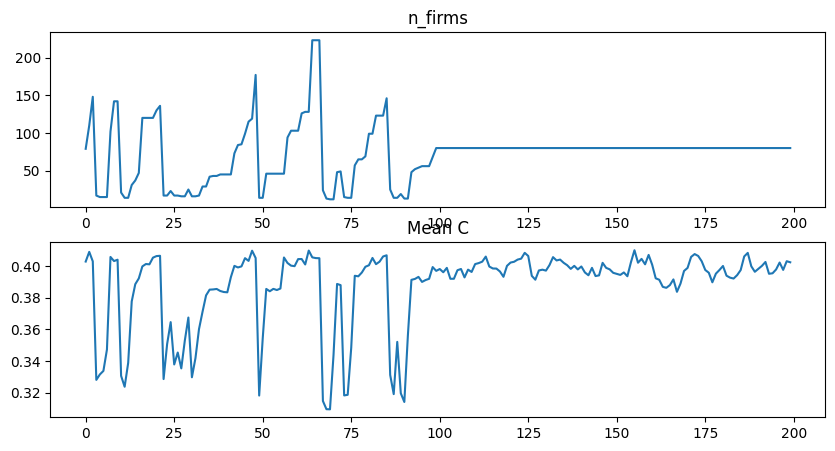

In [42]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.title('n_firms')
plt.plot(result2["n_firms"])
plt.subplot(2,1,2)
plt.title('Mean C')
plt.plot(result2["C_mean"])